In [1]:
import os
os.chdir('..')

In [3]:
import torch
import numpy as np
from gnn_library.util import load
from evaluate import evaluate_model
from instance_generator import sample_instances
from params import *
from util import _box_plots

%load_ext autoreload
%autoreload 2

In [7]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

models = {
	'GENConv': load('GNN_large_10_6', device),
	'DeeperGCN': load('other_GNN_deeperGCN', device),
	'GATv2Conv': load('other_GNN_Gatv2Conv', device),
	'GraphConv': load('other_GNN_GraphConv', device),
	'GCNConv': load('other_GNN_GCNConv', device),
}
_, args = load('GNN_large_10_6', device)

PyTorch has version 1.12.0+cu102
Using device: cuda:4


## Box plot baseline evaluation

#### Evaluate CRs on all graph configurations

In [23]:
import pickle # TODO remove

rng = np.random.default_rng()
num_trials = 150
batch_size = 500
node_configs = [(20, 10)]
graph_configs = MAIN_TESTING_GRAPH_CONFIGS
baselines_kwargs = {}

data = {node_config: {str(graph_config): {} for graph_config in graph_configs} for node_config in node_configs}

for node_config in node_configs:
    for graph_config in graph_configs:
            print(node_config, graph_config)
            instances = sample_instances(
                *node_config,
                num_trials,
                rng,
                args.__dict__,
                **graph_config
            )
            for model_name, (GNN, args) in models.items():
                cr_ratios, _ = evaluate_model(
                    meta_model=None,
                    meta_model_type=None,
                    base_models=[GNN],
                    instances=instances,
                    batch_size=batch_size,
                    rng=rng,
                    num_realizations=20,
                    baselines=[],
                    **baselines_kwargs
                )

                data[node_config][str(graph_config)][model_name] = cr_ratios['learned']

            with open(f"experiments/box_plots_multiple_gnns.pickle", 'wb') as handle:
                pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


(20, 10) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
GENConv


/home/alexhay/GNN-OBM/torch_converter.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mask)


DeeperGCN
GATv2Conv
GraphConv
GCNConv
(20, 10) {'graph_type': 'GEOM', 'q': 0.25, 'd': 2, 'weighted': True}
GENConv
DeeperGCN
GATv2Conv
GraphConv
GCNConv
(20, 10) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
GENConv
DeeperGCN
GATv2Conv
GraphConv
GCNConv
(20, 10) {'graph_type': 'GM'}
GENConv


/home/alexhay/GNN-OBM/torch_converter.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mask)


DeeperGCN
GATv2Conv
GraphConv
GCNConv


In [25]:
with open(f"experiments/box_plots_multiple_gnns.pickle", 'wb') as handle:
	pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Generate box plots

{'graph_type': 'ER', 'p': 0.5, 'weighted': True} {'GENConv': [0.9541628385319016, 0.92455710985735, 0.9493833947573155, 0.9234197756231675, 0.9303426366116689, 0.961589588919022, 0.9377148105861947, 0.9542389881116164, 0.9403157135651549, 0.9615642548913488, 0.9743202244074493, 0.9070371917600782, 0.9565355050628312, 0.9316268476722218, 0.9571968946760456, 0.9466784570681464, 0.932756635825864, 0.9574298907467498, 0.9399297719270804, 0.9137536968099804, 0.938897966664552, 0.9328530924026219, 0.9444817017253714, 0.9340329010791754, 0.9331275321267795, 0.9536392972068451, 0.9540499920764356, 0.9692117993697973, 0.9418976657504732, 0.9501627210869966, 0.9673232991470909, 0.9273748383532929, 0.9621739881562226, 0.916128956546671, 0.9243368112594805, 0.9004091232592726, 0.9471754024854139, 0.9472335097921718, 0.8946287488903734, 0.9427784159210633, 0.8747355421633195, 0.9389178903177422, 0.9527677348812409, 0.9586649774223958, 0.9583813154809138, 0.9619292939917493, 0.9599274488367122, 0.92

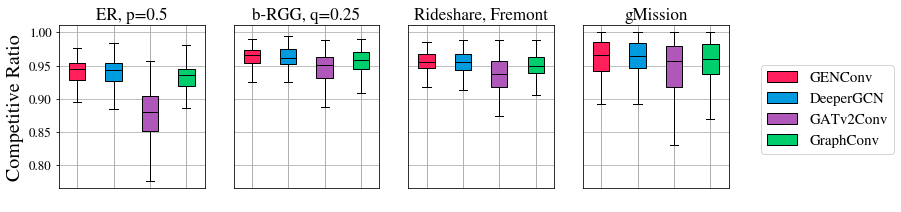

In [30]:
results = {}
for graph_type, val in data[node_configs[0]].items():
		
	results[graph_type] = val
	# results[graph_type].pop('GCNConv')
	print(f"{graph_type} {val}")

_box_plots(results, lambda graph_type: f"GNN2_classify_{graph_type} {node_config[1]}x{node_config[0]}")

In [30]:
for label in ['learned', 'greedy', 'greedy_t', 'lp_rounding', 'naor_lp_rounding', 'pollner_lp_rounding']:
    print(label)
    print(np.nanmean(results["{'graph_type': 'ER', 'p': 0.5, 'weighted': True}"][label]))
    print(np.nanstd(results["{'graph_type': 'ER', 'p': 0.5, 'weighted': True}"][label]))
    print(np.nanmax(results["{'graph_type': 'ER', 'p': 0.5, 'weighted': True}"][label]))
    print(np.nanmin(results["{'graph_type': 'ER', 'p': 0.5, 'weighted': True}"][label]))
    print()

learned
0.9375406822946877
0.020488721688707814
0.9770632668156484
0.8906075746635768

greedy
0.8832660468014378
0.042111343516759936
0.9695886660041662
0.773918419580194

greedy_t
0.8943132303877158
0.034755100745926415
0.9634036702937727
0.8235931314200542

lp_rounding
0.9160779507565222
0.021609797545870682
0.9605348860405354
0.8639270548190373

naor_lp_rounding
0.9138430650193456
0.021827750625309453
0.9597701078420974
0.859539364718328

pollner_lp_rounding
0.9200531820781406
0.019780583620047858
0.9602326865163937
0.8708671887402302

